<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/models/pictures_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preparation

In [2]:
#@title remove repos from disc
%cd /content
!rm -r airbnb_price

/content
rm: cannot remove 'airbnb_price': No such file or directory


In [3]:
#@title Clone repo
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 348, done.
remote: Counting objects: 100% (348/348), done.
remote: Compressing objects: 100% (327/327), done.
remote: Total 348 (delta 171), reused 92 (delta 15), pack-reused 0
Receiving objects: 100% (348/348), 2.65 MiB | 7.47 MiB/s, done.
Resolving deltas: 100% (171/171), done.


In [4]:
#@title add paths to library search path
import sys 

sys.path.append("/content/airbnb_price/custom_functions")

In [23]:
#@title Imports and drive
import os
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import requests
from tqdm import tqdm

# own modules
import general_utils as gu
import picture_model_utils as pu



from google.colab import drive

#@title Mount drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [6]:
#@title define device

# device
device = gu.get_device()
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB
4 CPUs available


# 1. Model thumbnail pictures

In [ ]:
thumbnails_dir = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_raw"
response_dir = "/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_response"

In [ ]:
# make train_dataset and val_dataset and respective dataloader with thumbnails

# load moments
thumbnails_moments = np.load("/content/drive/MyDrive/Colab/airbnb/data/thumbnails/thumbnails_moments.npy")
thumbnails_moments = torch.from_numpy(thumbnails_moments)

# initialize dataset and dataloader
dataset = pu.Dataset(picture_dir=thumbnails_dir, response_dir = response_dir, channel_moments=thumbnails_moments, ndata=11000)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [8000, 3000], generator=torch.Generator().manual_seed(42))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
# calculate root mse to get reference value for model performance
logprice = []
for i in tqdm(range(len(val_dataset))):
    logprice.append(val_dataset[i][1])

100%|██████████| 3000/3000 [00:21<00:00, 139.95it/s]


In [ ]:
mean_logprice = np.mean(logprice)
squared_error = (np.array(logprice) - mean_logprice) ** 2
mean_squared_error = np.mean(squared_error)
root_mean_squared_error = np.sqrt(mean_squared_error)
root_mean_squared_error

0.66298217

In [ ]:
#@title define models classes
class Model(torch.nn.Module):
    def __init__(self, feature_extractor, finalizer):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.finalizer = finalizer

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.finalizer(x)
    
        return x

class Finalizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(512)
        self.conv2 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(512)
        self.conv3 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(512)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.linear1 = torch.nn.Linear(in_features = 25088, out_features=4096)
        self.bn4 = torch.nn.BatchNorm1d(4096)
        self.drop1 = torch.nn.Dropout()
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=1)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool1(x)
        x = torch.flatten(x, start_dim=1)
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.drop1(x)
        x = self.linear2(x)

        return x
        

In [ ]:
# define feature extractor
vgg = torchvision.models.vgg19(pretrained=True)
feature_extractor = vgg.features[0:31]

In [ ]:
# define finalizer
finalizer = Finalizer()

In [ ]:
# define model
model = Model(feature_extractor=feature_extractor, finalizer=finalizer)

In [ ]:
model = model.to(device)

In [ ]:
# freeze parameters in feature extractor
# for name, p in model.named_parameters():
#     if "feature_extractor" in name:
#         p.requires_grad = False

In [ ]:
# define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#@title define train functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
    
def train(dataloader, optimizer, model, loss_fn, device, master_bar, scaler):
    model.train()
    epoch_loss = []

    for image, target in fastprogress.progress_bar(dataloader, parent=master_bar):
        
        image, target = image.to(device), target.to(device)

        # zero gradient
        optimizer.zero_grad()

        # Forward pass
        prediction = model.forward(image)
        prediction = torch.squeeze(prediction)

        # loss calculation
        loss = loss_fn(prediction, target)

        # Backward pass
        scaler.scale(loss).backward() #loss.backward()
        scaler.step(optimizer) # optimizer.step()
        scaler.update()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(np.sqrt(loss.item()))

    return np.mean(epoch_loss)


def validate(dataloader, model, loss_fn, device, master_bar):
    model.eval()
    epoch_loss = []

    with torch.no_grad():
        for image, target in fastprogress.progress_bar(dataloader, parent=master_bar):
            
            image, target = image.to(device), target.to(device)

            # Forward pass
            prediction = model.forward(image)
            prediction = torch.squeeze(prediction)

            # loss calculation
            loss = loss_fn(prediction, target)

            # For plotting the train loss, save it for each sample
            epoch_loss.append(np.sqrt(loss.item()))

    return np.mean(epoch_loss)
    

def run_training(model, optimizer, loss_fn, device, num_epochs,
                 train_dataloader, val_dataloader, verbose=False):
  
    # technical stuff
    start_time = time.time()
    scaler = torch.cuda.amp.GradScaler()
    master_bar = fastprogress.master_bar(range(num_epochs))

    # instantiate losses
    train_loss = []
    val_loss = []

    for epoch in master_bar:

        # Train the model
        epoch_train_loss = train(train_dataloader, optimizer, model, loss_fn, device, master_bar, scaler)
        #Validate the model
        epoch_val_loss = validate(val_dataloader, model, loss_fn, device, master_bar)

        # Save loss and acc for plotting
        train_loss.append(epoch_train_loss)
        val_loss.append(epoch_val_loss)


        if verbose:
            master_bar.write(
                f'Train root mse: {epoch_train_loss:.4f}, val root mse: {epoch_val_loss:.4f}')

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_loss, val_loss
    

In [ ]:
image, target = next(iter(train_dataloader))

In [ ]:
plt.imshow(torch.permute(image[5], (1, 2 ,0)))

In [ ]:
train_loss, val_loss = run_training(model=model, optimizer=optimizer, loss_fn=loss_fn, device=device, num_epochs=100,
                                    train_dataloader=train_dataloader, val_dataloader=val_dataloader, verbose=True)

# scrap

In [164]:
dir = os.listdir("/content/drive/MyDrive/Colab/airbnb/data/hostpics/hostpics_raw")

In [218]:
rand_index = np.random.randint(0, 11000)
test = np.load("/content/drive/MyDrive/Colab/airbnb/data/hostpics/hostpics_raw/" + dir[rand_index])

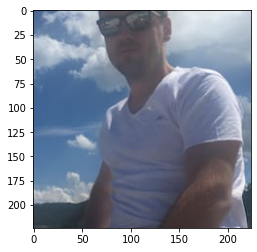

In [219]:
plt.imshow(test)

In [220]:
test = torch.from_numpy(test)
test = test.reshape(1, 3, 224, 224)
test = test.type(torch.float)
test /= 255
test = test - torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
test = test / torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)

In [221]:
# vgg = torchvision.models.vgg19(pretrained=True)

In [222]:
with torch.no_grad():
    vgg = vgg.eval()
    result = vgg(test)

In [223]:
argmax = result.argmax()

In [224]:
# %%capture
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [225]:
# labels = pd.read_csv("/content/imagenet_classes.txt", header=None).values

In [226]:
labels[argmax]

array(['window screen'], dtype=object)